In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench_old
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.adiabatic_pulse_calib
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments

# State tomography analysis functions

Measurement occurs along 3^3=27 axes, each of which can give one of 2^3=8 values

In [52]:
meas_order = meas.three_qubit.threeQ_state_tomo.make_3q_meas_order()
calib_order = meas.three_qubit.threeQ_state_tomo.make_3q_calib_order()

calib_order_numeric = np.zeros_like(calib_order)
for i, label in enumerate(calib_order):
    label_numeric = ''
    for char in label:
        if char == 'g': label_numeric += '0'
        elif char == 'e': label_numeric += '1'
    calib_order_numeric[i] = label_numeric

print(meas_order)
print(calib_order)
print(calib_order_numeric)

['ZZZ' 'ZZX' 'ZZY' 'ZXZ' 'ZXX' 'ZXY' 'ZYZ' 'ZYX' 'ZYY' 'XZZ' 'XZX' 'XZY'
 'XXZ' 'XXX' 'XXY' 'XYZ' 'XYX' 'XYY' 'YZZ' 'YZX' 'YZY' 'YXZ' 'YXX' 'YXY'
 'YYZ' 'YYX' 'YYY']
['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']
['000' '001' '010' '011' '100' '101' '110' '111']


## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [5]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S123): # given 3 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S123[0] in 'IXYZ'
    assert S123[1] in 'IXYZ'
    assert S123[2] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    for q, Sq in enumerate(S123):
        if Sq == 'I': S123 = S123[:q] + 'Z' + S123[q+1:]
    return np.argwhere(meas_order == S123)[0][0]
print(meas_order)
print(order('IZX'))

['ZZZ' 'ZZX' 'ZZY' 'ZXZ' 'ZXX' 'ZXY' 'ZYZ' 'ZYX' 'ZYY' 'XZZ' 'XZX' 'XZY'
 'XXZ' 'XXX' 'XXY' 'XYZ' 'XYX' 'XYY' 'YZZ' 'YZX' 'YZY' 'YXZ' 'YXX' 'YXY'
 'YYZ' 'YYX' 'YYY']
1


Define psi basis

In [6]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S123 in meas_order:
    S1, S2, S3 = S123
    psi1 = psi_dict[S1]
    psi2 = psi_dict[S2]
    psi3 = psi_dict[S3]

    psi_basis.update({S123:[]})

    for state1 in (0,1):
        for state2 in (0,1):
            for state3 in (0,1):
                psi_basis[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]))

psi_basis_flat = []
for S123 in meas_order:
    for psi in psi_basis[S123]:
        # measure in psi basis
        psi_basis_flat.append(psi)

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [7]:
"""
n should be length 2^q=8 array containing single shot counts of measuring 000, 001, 010, 011, ... for measurement along axes i, j, k
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1, S2, S3: I, X, Y, Z
"""
print(calib_order)
def Tij(n, S1, S2, S3):
    assert 0 <= S1 <= 3 # Si represent pauli matrix indices
    assert 0 <= S2 <= 3
    assert 0 <= S3 <= 3
    signs = [1]*8
    S123 = [S1, S2, S3]
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1, so multiply sign by -1 if measuring in XYZ basis and measuring e
    for icalib, calib in enumerate(calib_order):
        for q in range(3):
            if S123[q] > 0 and calib[q] == 'e': signs[icalib] *= -1
    return np.sum(np.multiply(signs, n))


['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']


In [8]:
"""
Construct rho by adding together Tij for each of the 4^3 = 64 combinations of tensor product of 3 Pauli matrices
"""
def rho_from_counts(n):
    # print('shape', n.shape)
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            for k in range(4): # loop over pauli matrices for qubit 3
                o = order(i2s(i) + i2s(j) + i2s(k)) # get the right row of 8 elements in the n matrix
                # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
                rho += Tij(n[8*o:8*(o+1)], i, j, k) * qt.tensor(pauli(i), pauli(j), pauli(k))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()
    return rho

### Generate test data

In [9]:
def generate_counts(rho_id, n_tot, psi_basis_flat=None, evol_mats=None, noise=1.0):
    assert psi_basis_flat or evol_mats
    
    if psi_basis_flat is not None:
        print('Generating with psi basis')
        n = []
        # psi_basis = get_psi_basis(qubits)
        for psi in psi_basis_flat:
            # measure in psi basis
            n.append(n_tot * (psi.dag() * rho_id * psi).tr())
        n = np.reshape(np.array(n), (len(psi_basis.keys()), 4))
    
    elif evol_mats is not None:
        print('Generating with evol mats')
        evals, evecs = np.linalg.eig(rho_id)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(8)
            for i in range(4):
                evec_evol = evol_mat @ evecs.T[i]
                if evals[i] > 1e-12: n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)
        return n_evol

    # introduce gaussian noise
    if noise is not None:
        for n_psi in n:
            n_meas = sum(n_psi)
            new_nlast = -1
            while new_nlast < 0:
                new_n_excludelast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
                # preserve original total count per measurement
                new_nlast = n_meas - sum(new_n_excludelast)
            n_psi[:-1] = np.round(new_n_excludelast)
            n_psi[-1] = np.round(new_nlast)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [10]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

In [11]:
def fix_neg_counts(counts):
    counts = np.array(counts)
    assert len(counts.shape) == 2 # 2d array

    for i_n, n in enumerate(counts):
        orig_sum = sum(n)
        while len(n[n<0]) > 0: # repeat while still has neg counts
            # print(i_n, n)
            assert orig_sum > 0, 'Negative sum of counts'
            most_neg_ind = np.argmin(n)
            n += abs(n[most_neg_ind]) / (len(n) - 1)
            n[most_neg_ind] = 0

            # neg_indices = np.where(n<0)[0]
            # neg_vals = n[n<0]
            # n += abs(sum(neg_vals)) / len(n)
            # # len_pos = len(n) - len(neg_vals)
            # # n += abs(sum(neg_vals))/len_pos # redistribute the negative counts over all the positive elements evenly
            # # for i in neg_indices:
            # #     n[i] = 0

        n *= orig_sum/sum(n)

        # counts[i_n] = np.round(n)
    return counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [12]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


USE THESE (need to handle divide by 0 errors, which the more general method does not handle)

This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [13]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     # if det == 0: det = 1e-10
#     # if det00 == 0: det00 = 1e-10
#     # if det0011 == 0: det0011 = 1e-10
#     # if det0012 == 0: det0012 = 1e-10
#     # if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     # if rho33 == 0: rho33 = 1e-10
#     t = [
#         0 if det00 == 0 else np.sqrt(det/det00),
#         0 if det0011 == 0 else np.sqrt(det00/det0011),
#         0 if rho33 == 0 else np.sqrt(det0011/rho33),
#         np.sqrt(rho[3,3])
#         ]
#     t56 = 0 if det00*det0011 == 0 else det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])

#     t78 = 0 if rho33*det0011 == 0 else det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])

#     t910 = 0 if rho33 == 0 else rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])

#     t1112 = 0 if rho33*det0011 == 0 else det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])

#     t1314 = 0 if rho33 == 0 else rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])

#     t1516 = 0 if rho33 == 0 else rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])

#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Not using this

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. This doesn't seem to work?

In [14]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: T[i, j] = 0
                else: T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    # assert(len(t)==16)
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution states" to match the MLE.

Note: uses QSwitch and related classes

In [15]:
"""
Get effective drive rate in GHz
"""
sigma_n = 4 # total number of sigmas to keep in gaussian
def amp_eff(sigma_ns, sigma_n=sigma_n):
    return 1/4 / (sigma_ns * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

# Return what phi should be when driving in the other quadrature, i.e. cos(wt+phi) <-> sin(wt-phi)
def phase_to_other_drive(phase):
    return np.pi - phase

In [16]:
def get_evol_mats(qubits, qfreqs, ZZs, pulse_dict, dt=0.01):
# def get_evol_mats(qubits, qfreqs, alphas, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    # print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evol_mats = dict()
    device = QSwitch(qubit_freqs=qfreqs, ZZs=ZZs, cutoffs=[2,2], useZZs=True, is2Q=True)

    # Get the pi/2 pulse lengths for both qubits
    pulse_cfgs_XX = pulse_dict['XX']
    pi2_lens = [0]*2
    pi2_types = [None]*2
    for pulse_name, pulse_cfg in pulse_cfgs_XX.items():
        if pulse_cfg['flag'] != 'ZZcorrection': continue
        drive_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
        assert drive_qubit in qubits

        # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian
        drive_qubit = qubits.index(drive_qubit)
        pi2_types[drive_qubit] = pulse_cfg['type']
        if pi2_types[drive_qubit] == 'gauss':
            pulse_len = pulse_cfg['sigma']
        elif pi2_types[drive_qubit] == 'const':
            pulse_len = pulse_cfg['length']
        pi2_lens[drive_qubit] = soc.cycles2us(pulse_len, gen_ch=pulse_cfg['ch']) * 1e3
    assert 0 not in pi2_lens

    for basis, pulse_cfgs in tqdm(pulse_dict.items()):
        # print(basis)
        seq = PulseSequence()

        # print('all pulse_cfgs for basis', basis, pulse_cfgs)
        for drive_qubit in (0, 1):
            if basis[drive_qubit] == 'Z':
                device.add_precise_pi_pulse(seq, 'gg', 'gg', amp=0, drive_qubit=drive_qubit, wd=-1, phase=0, type=pi2_types[drive_qubit], t_pulse=pi2_lens[drive_qubit], t_offset=0, sigma_n=sigma_n)
                continue

            # Find the appropriate pulse cfg for the pulse
            for pulse_name, pulse_cfg in pulse_cfgs.items():
                # print('flag', pulse_cfg['flag'])
                if pulse_cfg['flag'] != 'ZZcorrection': continue
                # print(pulse_name)
                pulse_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
                assert pulse_qubit in qubits
                # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian, proceed if this is the drive qubit we want
                if qubits.index(pulse_qubit) != drive_qubit: continue

                ch = pulse_cfg['ch']
                freq = pulse_cfg['freq_MHz']
                freq += 4000 if freq < 1000 else 0
                wd = 2*np.pi * freq * 1e-3
                # phase = pulse_cfg['phase_deg'] * np.pi/180
                phase = phase_to_other_drive(pulse_cfg['phase_deg'] * np.pi/180) # convert from the sin wavefunction used in definition of rfsoc drive to the cos wavefunction used for simulations
                type = pulse_cfg['type']

                pulse_length = pi2_lens[drive_qubit] # ns
                assert pulse_length > 1 # 1 ns
                amp = amp_eff(pulse_length, sigma_n=sigma_n)
                # print(pulse_length, amp)

                new_state = 'gg'
                new_state = new_state[:drive_qubit] + 'e' + new_state[drive_qubit+1:]
                device.add_precise_pi_pulse(seq, 'gg', new_state, amp=amp, drive_qubit=drive_qubit, wd=wd, phase=phase, type=type, t_pulse=pulse_length, t_offset=0, sigma_n=sigma_n)

                # # print('all params')
                # print('fd', wd/2/np.pi)
                # print('pulse length', pulse_length)
                # print('amp', amp)
                # print('phase rad', phase)
                # print('drive q', drive_qubit)

        total_length = sum(seq.get_pulse_lengths())
        nsteps = int(total_length // dt + 1)
        times = np.linspace(0, total_length, num=nsteps)

        evol_mats.update({basis:[]})
        for state0 in range(2):
            for state1 in range(2):
                psi0 = qt.ket(str(state0)+str(state1))
                evol_ket_all_times = device.evolve_array(psi0, seq, times, nsteps=100000, use_str_solve=False, progress=False)

                evol_ket = device.evolve_unrotate(times=[times[-1]], result=[evol_ket_all_times[-1]], progress=False)[-1]

                evol_mats[basis].append(evol_ket.unit())
        evol_mats[basis] = np.hstack(evol_mats[basis])

    return evol_mats

### MLE functions

In [17]:
def run_MLE_standard(n, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # return np.log(val)
        return val
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [18]:
def run_MLE_ZZ(n, evol_mats, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = (rho_id.full() + rho_from_counts(n))/2
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        # for psi, n_val in zip(evol_mats, n.flatten()):
        #     psi = psi.full()
        #     proj = (psi.conj().T @ rho @ psi)[0][0]
        #     if proj != 0:
        #         val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # # return np.log(val)
        # return val

        evals, evecs = np.linalg.eig(rho)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(4)
            for i in range(4):
                if evals[i] < 1e-12: continue
                evec_evol = evol_mat @ evecs.T[i]
                n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)

        for n_th, n_expt in zip(n_evol.flatten(), n.flatten()):
            if n_th != 0: val += abs((n_th - n_expt)**2 / n_th)
        return val

    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [19]:
def run_MLE(n, ZZ_correction=False, evol_mats=None, rho_guess=None, rho_id=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_mats, rho_guess=rho_guess, rho_id=rho_id, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, rho_id=rho_id, method=method)

Optimize over virtual Z gates on ideal rho 

In [86]:
def z_gate_3q(phi1, phi2, phi3):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2), qt.qip.operations.gates.rz(phi3)) 

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_MLE, rho_id, nphi=100):
    phis = np.linspace(0, 2*np.pi, nphi)
    best_fid = 0
    best_phis = [0, 0, 0]
    best_rho_id = rho_id
    for phi1 in tqdm(phis):
        for phi2 in phis:
            for phi3 in phis:
                z_phi123 = z_gate_3q(phi1, phi2, phi3)
                rho_id_rot = (z_phi123*rho_id*z_phi123.dag()).unit()
                fid = qt.fidelity(rho_MLE, rho_id_rot)**2
                # print(fid)
                if fid > best_fid:
                    best_fid = fid
                    best_phis = [phi1*180/np.pi, phi2*180/np.pi, phi3*180/np.pi]
                    best_rho_id = rho_id_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_MLE, rho_id)**2)*100}')
    return best_rho_id, best_phis, best_fid

# Plotting functions

In [21]:
# from qutip.visualization import hinton

In [54]:
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=24)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=18, rotation=45)
    plt.yticks(np.arange(len(mat)), labels, fontsize=18)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=14)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=20)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None, cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    labels = calib_order_numeric

    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=24)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    plt.show()

def show_plot_rho_3d(rho_MLE, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is not None: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = calib_order_numeric

    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_MLE).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_MLE).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    plt.show()

# Run experiment and analysis

In [23]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'\\'+filename
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [24]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
# expt_path=os.getcwd()+'\data\data_221215'
expt_path=os.getcwd()+'\data\data_230217'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [25]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and958_reset.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and958_reset.yml


In [26]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [27]:
im = InstrumentManager()

In [28]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 7.0


In [28]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

## Run experiment and acquire data

### Test 3Q tomo

In [99]:
tomo_qubits = [0, 2, 3] # which qubit/resonator we want to probe

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.6082793015007, 0, 3462.660233985849, 3462.4180842997853], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.5, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 19375, 8131, 5854], 'sigma': [0.03157, 0.045, 0.07, 0.07043], 'type': 'gauss'}, 'pi_ge_adiabatic': {'gain': [-1, 25000, -1, -1], 'mu': [0, 6, 0, 0], 'beta': [0, 4, 0, 0], 'period': [0, 0.48, 0, 0]}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.021

  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)


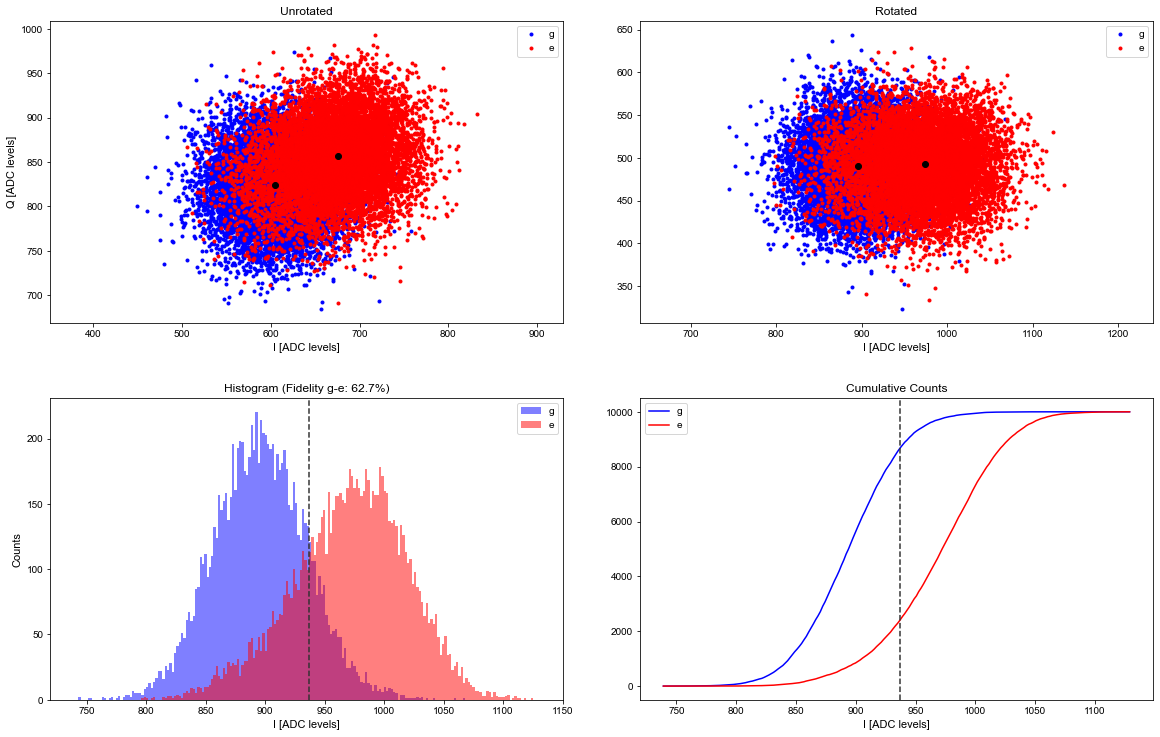

Qubit  (2)


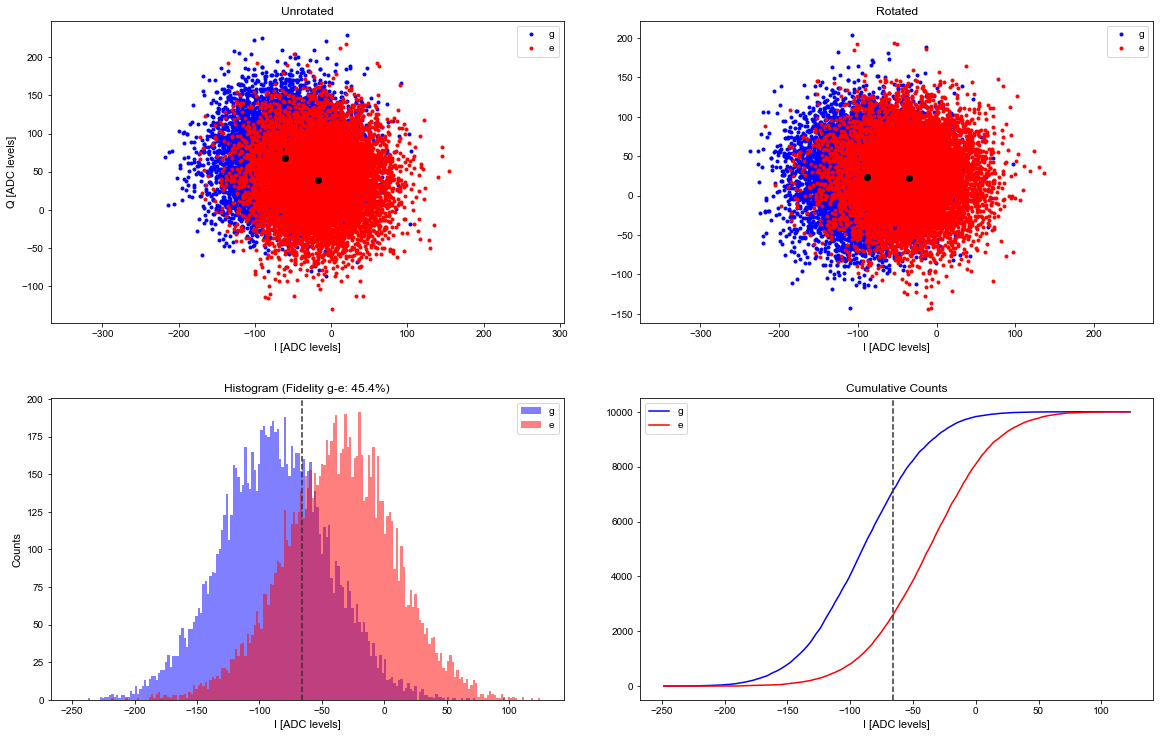

Qubit  (3)


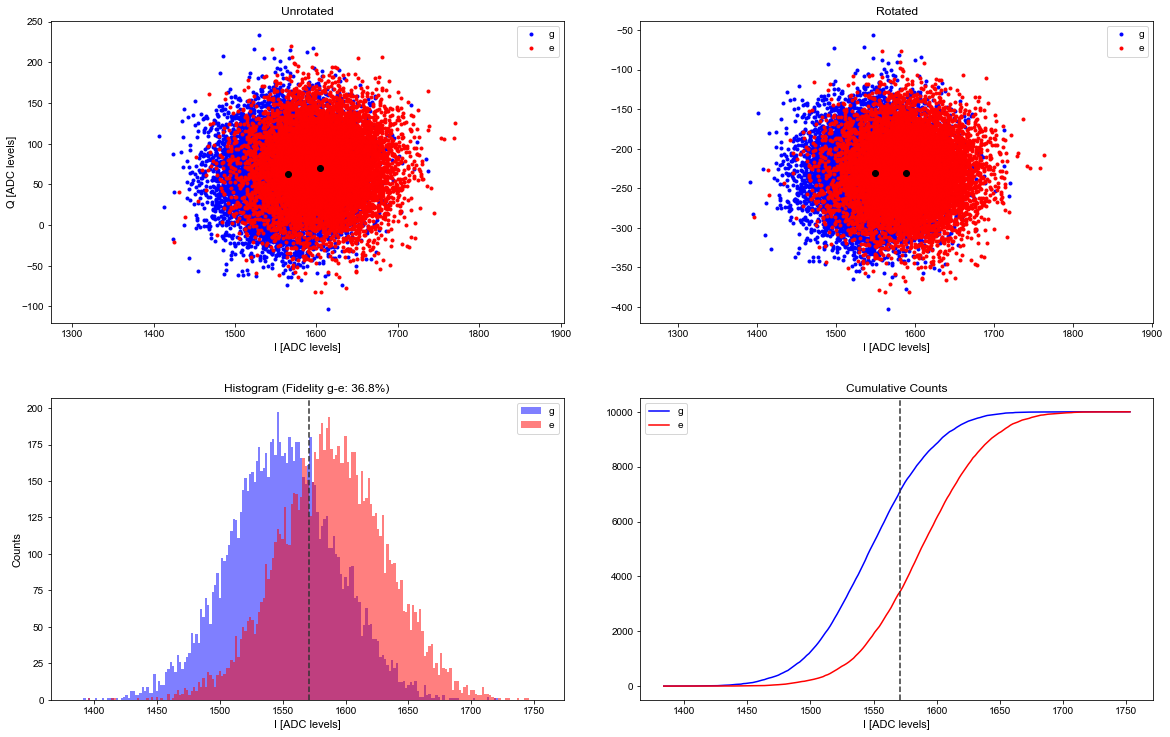

thresholds [936.9733330351623, 0, -65.60222770128473, 1571.2264548934736]
angles [-24.989961609042787, 0, 32.88107109134772, -10.760795048347441]


  0%|          | 0/27 [00:00<?, ?it/s]

In [100]:
tomoExpt = meas.TestStateTomo3QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_3q_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}{tomo_qubits[2]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=5000, # reps per measurement basis
    singleshot_reps=10000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
)

print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [101]:
tomo = tomoExpt
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

print(meas_order)
print(calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo_raw, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

n_tomo = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))

['ZZZ' 'ZZX' 'ZZY' 'ZXZ' 'ZXX' 'ZXY' 'ZYZ' 'ZYX' 'ZYY' 'XZZ' 'XZX' 'XZY'
 'XXZ' 'XXX' 'XXY' 'XYZ' 'XYX' 'XYY' 'YZZ' 'YZX' 'YZY' 'YXZ' 'YXX' 'YXY'
 'YYZ' 'YYX' 'YYY']
['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']
Tomography counts
[[ 309  615  141  270  847 1721  363  734]
 [ 415  456  177  188 1266 1373  533  592]
 [ 501  447  197  202 1380 1186  565  522]
 [ 232  417  248  396  642 1184  637 1244]
 [ 309  304  305  366  916  942  894  964]
 [ 353  388  371  382  881  862  859  904]
 [ 235  430  271  486  587 1157  630 1204]
 [ 327  360  369  404  800  948  862  930]
 [ 310  293  311  334  906  926  880 1040]
 [ 729 1345  283  576  509  960  189  409]
 [ 982 1112  436  458  640  753  272  347]
 [1078  939  452  412  767  781  295  276]
 [ 504  929  492  972  379  707  348  669]
 [ 733  754  647  787  464  560  517  538]
 [ 721  760  739  743  512  533  455  537]
 [ 511  953  519  980  325  699  364  649]
 [ 667  750  716  785  467  542  543  530]
 [ 739  704  737  748  483  524  50

### Qram experiment

In [119]:
tomo_qubits = [1, 2, 3] # which qubit/resonators to do tomo on

In [120]:
n_tomo_raw_rounds = []

n_calib_rounds = []
n_tomo_rounds = []

In [121]:
save_data = False

In [135]:
init_state = '|1>|0+1>'

TOMO QUBITS [1, 2, 3]
init state |1>|0+1>


  0%|          | 0/1 [00:00<?, ?it/s]

time step size [cycles]: -9223372036854775808


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (1)


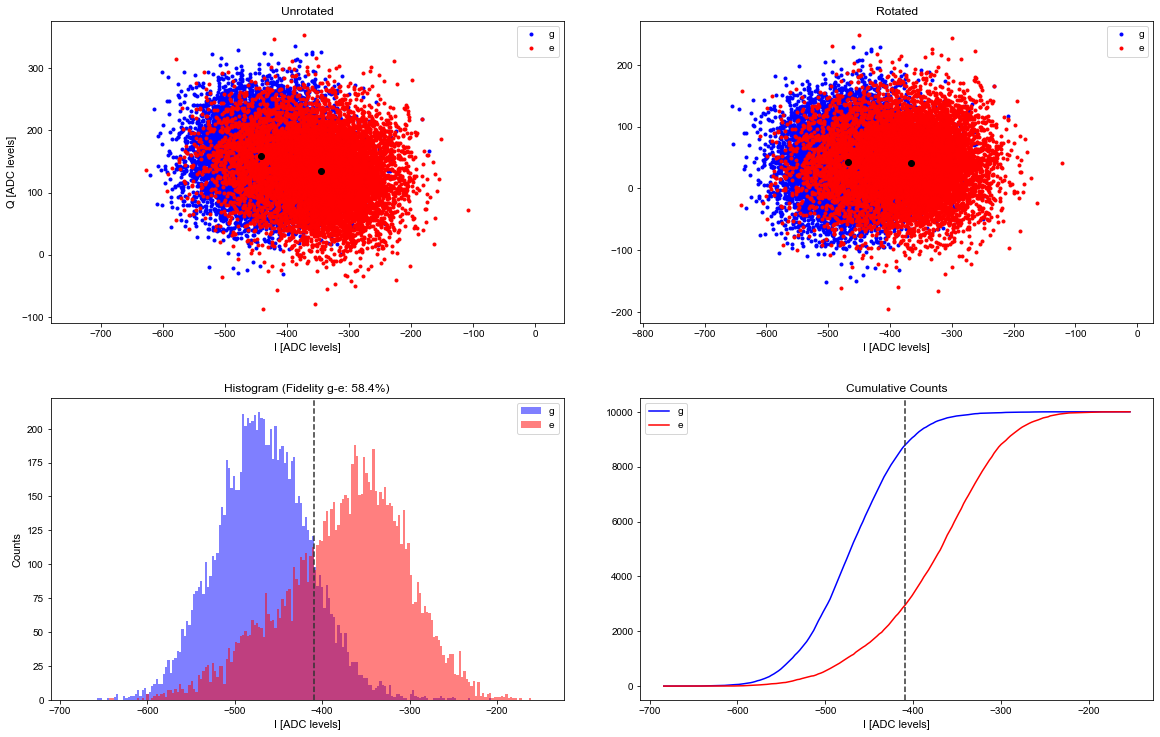

Qubit  (2)


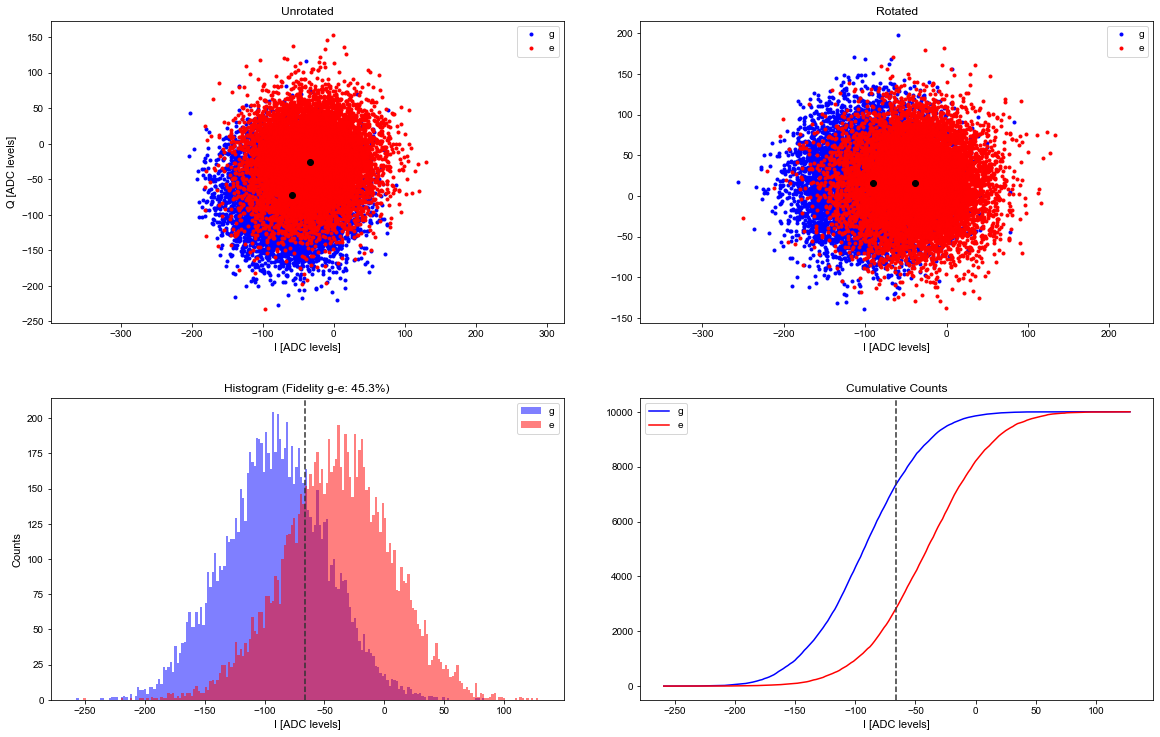

Qubit  (3)


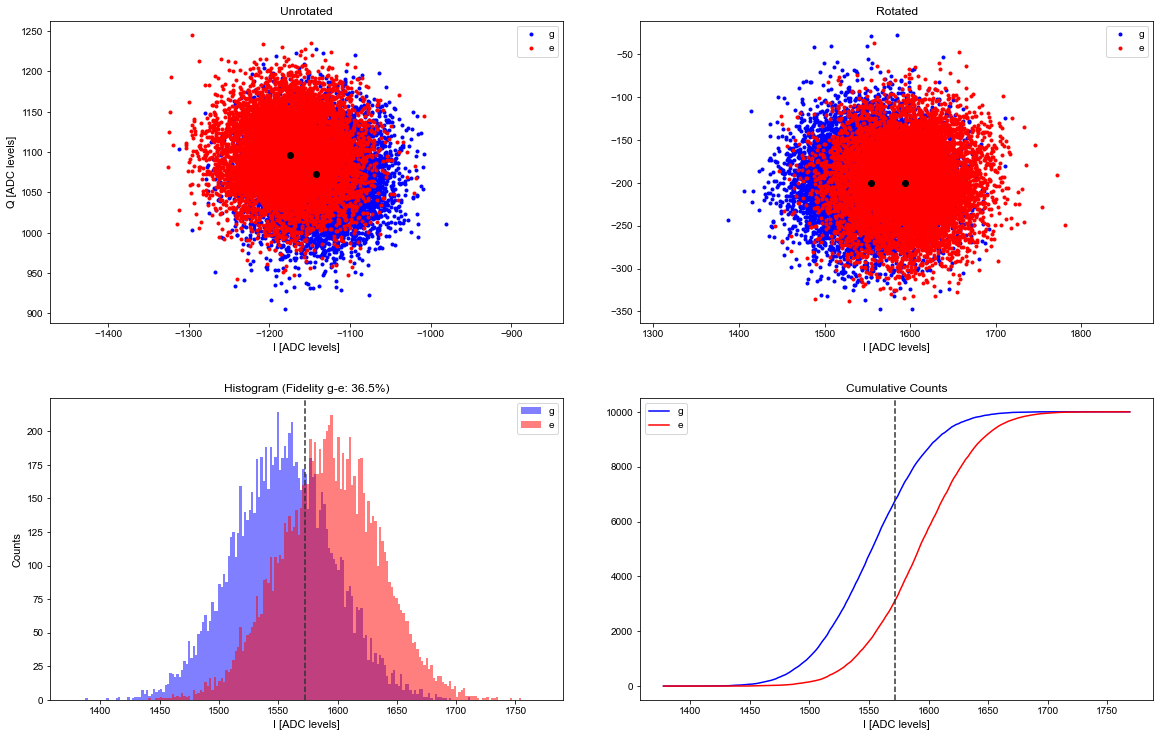

thresholds [0, -409.20803554709903, -66.42889201858722, 1572.1421709628885]
angles [0, 14.603987214729136, -61.15403608367809, -144.09318736154663]


  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 1/1 [03:01<00:00, 181.42s/it]


In [136]:
qramExpts = []
nrepeat = 1
print('TOMO QUBITS', tomo_qubits)
print('init state', init_state)

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )

    # span = 2.161196963262976 # total time [us]
    # span = 1.1659462011134218 # total time [us]
    span = np.inf
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        reps=7000, # number of reps per time step,
        # singleshot_reps=1, # reps per state for singleshot calibration
        singleshot_reps=10000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        # thresholds=[48.765112894093534, 96.26256512031452, 332.5698328167488, 907.1402810621812],
        # ge_avgs=None, # (optional) don't rerun singleshot and instead use this
        # angles=[54.85719696454403, -4.061056979857183, 77.35730820785261, -80.28753842272687]
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        init_state=init_state,
    )

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.go(analyze=False, display=False, progress=nrepeat<2, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # tomo = qramExpt
    # data = tomo.data
    # n_tomo_raw = np.array(data['counts_tomo'])
    # n_calib = np.array(data['counts_calib'])

    # n_tomo_raw_rounds.append(n_tomo_raw)
    # n_calib_rounds.append(n_calib)
    # n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

    qramExpts.append(qramExpt)
    if save_data: qramExpt.save_data()

In [ ]:
data, attrs = prev_data(expt_path, 'data_230217/00013_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# data = None

style.use('default')
qramExpt.analyze(data=data)
qramExpt.display(data=data, err=False, saveplot=True)

In [ ]:
qramExpt.save_data()

post processing average counts

In [137]:
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    n_tomo_raw = np.array(data[f'counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    # print('Tomography counts')
    # print(n_tomo_raw)
    # print('Confusion matrix counts')
    # print(n_calib)
    # print('Confusion matrix corrected tomo matrix will be')
    # print(correct_readout_err(n_tomo_raw, n_calib))
    # print('Negative counts corrected tomo matrix will be')
    # print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

    print(n_calib)
    print(n_tomo_raw)
    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)
    n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

pulse_dict = qramExpts[-1].pulse_dict

[[4183 2066 1599  844  604  320  237  147]
 [1750 4196  684 1620  400  840  151  359]
 [1491  793 4243 2085  238  136  664  350]
 [ 716 1432 1770 3886  286  431  490  989]
 [1339  672  556  287 3408 1697 1382  659]
 [ 757 1661  299  688 1452 3321  581 1241]
 [ 578  332 1678  811 1154  572 3331 1544]
 [ 356  713  924 2082  577 1048 1360 2940]]
[[1285  756 1733  900  687  644  579  416]
 [ 931 1014 1367 1291  634  660  510  593]
 [ 985 1023 1332 1293  628  652  576  511]
 [1476  807 1507  827  563  581  647  592]
 [1126 1174 1124 1180  595  589  605  607]
 [1127 1189 1191 1179  558  617  570  569]
 [1416  867 1508  864  585  607  626  527]
 [1118 1207 1160 1148  554  594  624  595]
 [1042 1153 1223 1140  596  666  574  606]
 [1077  839 1253  773  731  717 1005  605]
 [ 971  984  987  964  754  746  813  781]
 [1009 1020  929  834  772  768  876  792]
 [1116  800 1185  750  939  633  930  647]
 [ 934 1000 1024 1009  808  720  738  767]
 [1030  972 1023  980  779  733  733  750]
 [1241  84

In [138]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
n_tomo_corrected = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))
print(len(n_tomo_raw_rounds))

print('Average raw tomography counts')
print(n_tomo_raw)
print('Std raw tomography counts')
print(n_tomo_raw_std)
print('Average confusion matrix counts')
print(n_calib)
print('Std confusion matrix counts')
print(n_calib_std)
print('Average n_tomo')
print(n_tomo_avg)
print('Std n_tomo')
print(n_tomo_std)
print('Corrected average tomo with average calib counts, corrected for neg counts')
print(n_tomo_corrected)

# n_tomo = n_tomo_avg
n_tomo = n_tomo_corrected

1
Average raw tomography counts
[[1285.  756. 1733.  900.  687.  644.  579.  416.]
 [ 931. 1014. 1367. 1291.  634.  660.  510.  593.]
 [ 985. 1023. 1332. 1293.  628.  652.  576.  511.]
 [1476.  807. 1507.  827.  563.  581.  647.  592.]
 [1126. 1174. 1124. 1180.  595.  589.  605.  607.]
 [1127. 1189. 1191. 1179.  558.  617.  570.  569.]
 [1416.  867. 1508.  864.  585.  607.  626.  527.]
 [1118. 1207. 1160. 1148.  554.  594.  624.  595.]
 [1042. 1153. 1223. 1140.  596.  666.  574.  606.]
 [1077.  839. 1253.  773.  731.  717. 1005.  605.]
 [ 971.  984.  987.  964.  754.  746.  813.  781.]
 [1009. 1020.  929.  834.  772.  768.  876.  792.]
 [1116.  800. 1185.  750.  939.  633.  930.  647.]
 [ 934. 1000. 1024. 1009.  808.  720.  738.  767.]
 [1030.  972. 1023.  980.  779.  733.  733.  750.]
 [1241.  841. 1187.  766.  916.  625.  788.  636.]
 [ 976. 1118. 1047.  953.  672.  770.  773.  691.]
 [ 987.  937. 1078.  951.  814.  736.  842.  655.]
 [1228.  933. 1685.  950.  590.  580.  633.  401.]

## Run analysis

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [115]:
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric):
    psis.update({label_numeric:psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))

In [59]:
psi_id = qt.tensor(psiZ[1]+psiZ[0], psiZ[0], psiZ[1]+psiZ[0]).unit()
rho_id = qt.ket2dm(psi_id)

In [62]:
def get_qram_q123_state(init_state, post_select=False, post_select_state=None):
    if init_state == '|0>|0>': return qt.ket2dm(psis['000']).unit()
    elif init_state == '|0>|1>': return qt.ket2dm(psis['100']).unit()
    elif init_state == '|1>|0>': return qt.ket2dm(psis['010']).unit()
    elif init_state == '|1>|1>': return qt.ket2dm(psis['101']).unit()
    

    # below: switch in |0+1>
    assert len(init_state) > 5 and init_state[-5:] == '|0+1>', 'other input states not implemented'

    psi_in = init_state[:-5]
    psi_0in_123 = psis['000'] + psis['100']
    psi_1in_123 = psis['010'] + psis['101']
    if psi_in == '|0>': psi123 = psi_0in_123
    elif psi_in == '|1>': psi123 = psi_1in_123
    elif psi_in == '|0+1>': psi123 = psi_0in_123 + psi_1in_123
    elif psi_in == '|0+i1>': psi123 = psi_0in_123 + 1j*psi_1in_123
    else: assert False
    psi123 = psi123.unit()
    return qt.ket2dm(psi123).unit()

Generate test data

In [132]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
n_calib = qt.qeye(4).full()
print(fix_neg_counts(n_tomo))

Generating with evol mats
[[   0. 4000.    0. 4000.]
 [2002. 1998. 1919. 2081.]
 [2001. 1999. 1918. 2082.]
 [   0. 6527.    0. 1475.]
 [3265. 3263.  708.  767.]
 [3264. 3264.  707.  768.]
 [   0. 7077.    0.  926.]
 [3540. 3537.  444.  482.]
 [3539. 3538.  444.  482.]]


##### Run MLE without ZZ correction

In [139]:
print('init state', init_state)
rho_id = get_qram_q123_state(init_state)

init state |1>|0+1>


In [140]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
# rho_MLE_base = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
# print(rho_MLE_base)

 <ipython-input-14-1204771b6282>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-14-1204771b6282>: 14

Convergence: True


Fidelity (no ZZ correction): 0.28982940982627226
Purity (no ZZ correction): 0.3199268414029444
[[ 0.176+0.j    -0.019-0.009j  0.018-0.02j   0.012+0.012j  0.053-0.042j
  -0.021-0.002j -0.007-0.008j -0.03 +0.029j]
 [-0.019+0.009j  0.026+0.j    -0.012+0.029j -0.001+0.01j   0.013+0.007j
  -0.037+0.034j -0.007+0.004j  0.013-0.001j]
 [ 0.018+0.02j  -0.012-0.029j  0.42 +0.j     0.033-0.022j -0.01 -0.029j
  -0.008+0.017j -0.066-0.097j  0.012-0.001j]
 [ 0.012-0.012j -0.001-0.01j   0.033+0.022j  0.012+0.j    -0.004-0.004j
   0.008+0.028j -0.001-0.01j  -0.   +0.004j]
 [ 0.053+0.042j  0.013-0.007j -0.01 +0.029j -0.004+0.004j  0.1  +0.j
   0.021+0.01j  -0.016+0.011j  0.009+0.014j]
 [-0.021+0.002j -0.037-0.034j -0.008-0.017j  0.008-0.028j  0.021-0.01j
   0.176+0.j     0.011+0.031j  0.004-0.016j]
 [-0.007+0.008j -0.007-0.004j -0.066+0.097j -0.001+0.01j  -0.016-0.011j
   0.011-0.031j  0.061+0.j    -0.018-0.014j]
 [-0.03 -0.029j  0.013+0.001j  0.012+0.001j -0.   -0.004j  0.009-0.014j
   0.004+0.016j -0

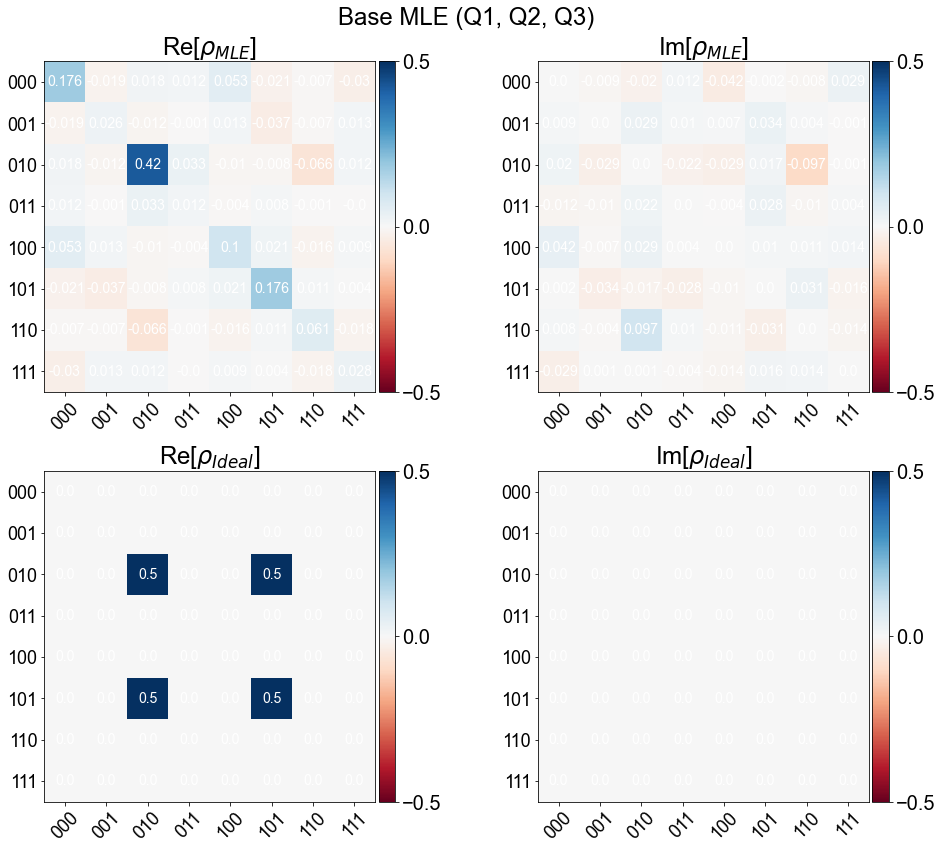

In [141]:
fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', cmax=0.5)

#### Run MLE with ZZ

Get evol mats for ZZ

In [46]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [219]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

q0, q1 = tomo_qubits
print('TOMO QUBITS', tomo_qubits)
ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_ge = np.array([f_ge[q0], f_ge[q1]])
# f_ef = np.array([f_ef[q0], f_ef[q1]])
# alphas = f_ef - f_ge # MHz
ZZs = np.array([[0., 0.], [0., 0.]])
# ZZs = np.array([[100., 100.], [100., 100.]])
ZZs[0, 1] = ZZs_4q[q0, q1]
ZZs[1, 0] = ZZs_4q[q1, q0]

print('qubit freqs', f_ge)
# print('alphas', alphas)
print('ZZs (MHz)', ZZs)
print('ZZ average (GHz)', 1e-3*np.average([ZZs[0,1], ZZs[1,0]]))
# print(pulse_dict)

evol_mats = get_evol_mats(qubits=tomo_qubits, qfreqs=f_ge*1e-3, ZZs=-ZZs*1e-3, pulse_dict=pulse_dict)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

print(evol_mats)

TOMO QUBITS [1, 3]
qubit freqs [3463.74256864 4415.18623279]
ZZs (MHz) [[ 0.         -1.06069598]
 [-1.09093474  0.        ]]
ZZ average (GHz) -0.0010758153613051036


100%|██████████| 9/9 [03:31<00:00, 23.47s/it]

{'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99997447+0.00714504j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99996909+0.00786219j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.9999925 +0.00387255j]]), 'ZX': array([[ 0.70839271-2.58867868e-04j,  0.70836691+3.48182705e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [-0.70581665-1.59997575e-03j,  0.70581597+5.29308890e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.71928712+6.94282994e-02j,  0.33945297-6.02660043e-01j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        -0.33474654-6.04773096e-01j,  0.71934044-6.42019535e-02j]]),

In [47]:
evol_mats_01 = {'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99998821+0.00485614j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99998985+0.00450619j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.99999703+0.00243893j]]), 'ZX': array([[ 0.70785571-5.64397393e-05j,  0.70785819+2.46940740e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [-0.70635637-9.82923392e-04j,  0.70634168+3.48039672e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.78655603+1.55162533e-01j, -0.59619397+4.26613693e-02j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.59597165+4.55192688e-02j,  0.78727991-1.51403761e-01j]]), 'ZY': array([[ 0.707884  +3.99977850e-05j, -0.00244099+7.07829742e-01j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [-0.00101169+7.06327984e-01j,  0.70637076+3.38390572e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.78664092+1.55163307e-01j, -0.04276855-5.96074076e-01j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.04562664-5.95851170e-01j,  0.78736501-1.51403088e-01j]]), 'XZ': array([[ 0.70884719+9.93432490e-05j,  0.        +0.00000000e+00j,
         0.7089011 +7.45792839e-04j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.75507633+1.25817245e-01j,
         0.        +0.00000000e+00j,  0.36748339-5.28991443e-01j],
       [-0.7053578 -2.45573105e-03j,  0.        +0.00000000e+00j,
         0.70530076+3.08284760e-03j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j, -0.36554014-5.29537694e-01j,
         0.        +0.00000000e+00j,  0.75487952-1.23616048e-01j]]), 'XX': array([[ 0.50102969+1.67672250e-04j,  0.53418053+8.89574375e-02j,
         0.50106778+6.24602594e-04j,  0.25994072-3.74259891e-01j],
       [-0.50061928-1.17115320e-04j,  0.53372702+8.88260795e-02j,
        -0.50065738-5.73667829e-04j,  0.25967804-3.73963234e-01j],
       [-0.55535892-1.08973335e-01j,  0.24123556+2.99496195e-01j,
         0.55521889+1.09458781e-01j, -0.44448825+1.06983607e-01j],
       [-0.42076817-3.17011202e-02j, -0.36881993-3.60641697e-01j,
         0.42070731+3.20728684e-02j,  0.5750585 -2.13006102e-01j]]), 'XY': array([[ 5.01049843e-01+2.36025198e-04j, -8.89322114e-02+5.34162475e-01j,
         5.01087864e-01+6.92982901e-04j,  3.74255236e-01+2.59915028e-01j],
       [-1.37490411e-04+5.00599026e-01j,  5.33760775e-01+8.87567418e-02j,
        -5.94029445e-04+5.00637101e-01j,  2.59637447e-01-3.74013861e-01j],
       [-5.55418894e-01-1.08973835e-01j, -2.99393437e-01+2.41248352e-01j,
         5.55278857e-01+1.09459337e-01j, -1.07049593e-01-4.44384318e-01j],
       [-3.17770099e-02+4.20683221e-01j, -3.68850933e-01-3.60686816e-01j,
         3.21486778e-02-4.20622300e-01j,  5.75122740e-01-2.13016480e-01j]]), 'YZ': array([[ 7.08917396e-01+6.02658119e-05j,  0.00000000e+00+0.00000000e+00j,
        -6.23734998e-04+7.08831023e-01j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  7.55083640e-01+1.25744097e-01j,
         0.00000000e+00+0.00000000e+00j,  5.28989365e-01+3.67496504e-01j],
       [-2.57667648e-03+7.05286809e-01j,  0.00000000e+00+0.00000000e+00j,
         7.05371139e-01+3.12223864e-03j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -5.29535507e-01+3.65553369e-01j,
         0.00000000e+00+0.00000000e+00j,  7.54886527e-01-1.23543127e-01j]]), 'YX': array([[ 5.01079408e-01+1.40058438e-04j,  5.34185694e-01+8.89056897e-02j,
        -5.38320302e-04+5.01018177e-01j,  3.74258421e-01+2.59949995e-01j],
       [-5.00668953e-01-8.95194119e-05j,  5.33732176e-01+8.87743760e-02j,
         4.87460863e-04-5.00607814e-01j,  3.73961767e-01+2.59687307e-01j],
       [-1.09057869e-01+5.55284725e-01j,  2.99494308e-01-2.41243349e-01j,
         5.55268270e-01+1.09500477e-01j, -4.44495644e-01+1.06940451e-01j],
       [-3.17702485e-02+4.20720698e-01j, -3.60637947e-01+3.68830006e-01j,
         4.20747548e-01+3.20993826e-02j,  5.75075196e-01-2.12949795e-01j]]), 'YY': array([[ 5.01099563e-01+2.08420206e-04j, -8.88804654e-02+5.34167642e-01j,
        -6.06687352e-04+5.01038274e-01j, -2.59924306e-01+3.74253767e-01j],
       [-1.09900650e-04+5.00648694e-01j,  5.33765927e-01+8.87050355e-02j,
        -5.00587541e-01-5.07821153e-04j,  3.74012395e-01+2.59646718e-01j],
       [-1.09058382e-01+5.55344690e-01j,  2.41256140e-01+2.99391549e-01j,
         5.55328244e-01+1.09501034e-01j, -1.07006447e-01-4.44391720e-01j],
       [ 4.20635741e-01+3.18461176e-02j, -3.60683067e-01+3.68861011e-01j,
         3.21751935e-02-4.20662523e-01j,  5.75139436e-01-2.12960166e-01j]])}

In [48]:
evol_mats_21 = {'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99999668+0.00257663j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99999762+0.00218211j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.99999938+0.00111735j]]), 'ZX': array([[ 0.70734374+0.00045639j,  0.7073932 +0.00161785j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.70686956-0.00021052j,  0.70681708+0.0013616j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.707402  +0.01367367j,  0.66150892-0.24840064j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.66091662-0.25016926j,  0.70750518-0.01181077j]]), 'ZY': array([[ 0.70745145+0.00056088j, -0.00134238+0.70728563j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.00048548+0.70676156j,  0.70692549+0.00125724j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.7075181 +0.01376921j,  0.24864119+0.66129241j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.25040955+0.66069932j,  0.70762149-0.01190567j]]), 'XZ': array([[ 0.70793184+0.00014722j,  0.        +0.j        ,
         0.70792951+0.00057327j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.70830285+0.02043924j,
         0.        +0.j        ,  0.69917961-0.09712103j],
       [-0.70628006-0.00098238j,  0.        +0.j        ,
         0.70628149+0.00139347j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.69877304-0.09800794j,
         0.        +0.j        ,  0.70804977-0.01951653j]]), 'XX': array([[ 0.50050181+0.00047613j,  0.50093475+0.01453703j,
         0.50049994+0.00077733j,  0.49449608-0.06860686j],
       [-0.50041596-0.00002177j,  0.50078107+0.01407811j,
        -0.50041436-0.00032292j,  0.49426918-0.06903225j],
       [-0.49975257-0.00926564j, -0.48645683+0.10928321j,
         0.49974859+0.00955655j,  0.46331156-0.18930342j],
       [ 0.46705188+0.17636791j, -0.49560637-0.06053459j,
        -0.46695055-0.17664025j,  0.50068878-0.02272911j]]), 'XY': array([[ 0.50057844+0.00055001j, -0.01433988+0.50086383j,
         0.50057652+0.00085127j,  0.06878879+0.49439379j],
       [-0.00021651+0.50033964j,  0.50085983+0.01400637j,
        -0.00051762+0.50033792j,  0.49433468-0.06911575j],
       [-0.49983442-0.00933313j, -0.10947267-0.48632877j,
         0.4998304 +0.00962408j,  0.18946961+0.4631532j ],
       [ 0.17653776-0.46689826j, -0.49569685-0.06047926j,
        -0.17681001+0.46679683j,  0.50076911-0.02279898j]]), 'YZ': array([[ 0.70792499+0.00014829j,  0.        +0.j        ,
        -0.00039289+0.7079365j ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.70829623+0.02044093j,
         0.        +0.j        ,  0.09729953+0.69916148j],
       [-0.0011623 +0.70628665j,  0.        +0.j        ,
         0.70627461+0.00139244j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.09818611+0.69875468j,
         0.        +0.j        ,  0.70804312-0.01951849j]]), 'YX': array([[ 0.50049696+0.00047688j,  0.50093008+0.01453822j,
        -0.00064982+0.50050498j,  0.0687331 +0.49448328j],
       [-0.50041111-0.00002252j,  0.50077639+0.0140793j ,
         0.00019542-0.50041928j,  0.06915844+0.49425626j],
       [-0.00939303+0.49975505j,  0.10916083+0.48648908j,
         0.49974374+0.00955574j,  0.46330667-0.18930305j],
       [ 0.17648858-0.46701148j, -0.06066087+0.49559563j,
        -0.46694625-0.17663786j,  0.50068405-0.02273041j]]), 'YY': array([[ 0.50057359+0.00055076j, -0.01434108+0.50085916j,
        -0.00072373+0.50058158j, -0.49438094+0.06891501j],
       [-0.00021727+0.5003348j ,  0.50085516+0.01400757j,
        -0.5003429 -0.00039014j,  0.06924196+0.49432175j],
       [-0.00946053+0.49983688j, -0.48636106+0.10935033j,
         0.49982555+0.00962327j,  0.18946924+0.46314831j],
       [-0.46685782-0.1766584j , -0.06060556+0.49568612j,
        -0.17680762+0.46679254j,  0.50076438-0.02280028j]])}


In [49]:
evol_mats_23 = {'XX': array([[ 0.50097733+0.00011056j,  0.50573034-0.03827494j,
         0.50086084+0.00055992j,  0.46985898+0.1489914j ],
       [ 0.09405602-0.49157708j, -0.05730794+0.50368369j,
         0.09447513-0.4913785j , -0.23442727+0.43333233j],
       [ 0.44295807-0.24555129j,  0.4769659 +0.09055508j,
        -0.44327558+0.24522178j, -0.42050242-0.26964293j],
       [ 0.03465621-0.49073292j, -0.34604594+0.36103451j,
        -0.03509267+0.49081693j,  0.46899046-0.21170595j]]), 'XY': array([[ 0.5009953 +0.00012732j, -0.03831952-0.50570874j,
         0.50087879+0.0005767j ,  0.14894338-0.46985568j],
       [ 0.49155102+0.09409736j, -0.05729312+0.50370366j,
         0.49135241+0.09451643j, -0.23442115+0.43335571j],
       [ 0.44297754-0.24553681j,  0.09052808-0.47696062j,
        -0.44329504+0.24520728j, -0.26961513+0.42050775j],
       [ 0.49072064+0.03468147j, -0.34603721+0.36105664j,
        -0.49080464-0.03511793j,  0.46899062-0.21173042j]]), 'XZ': array([[ 0.70775458+0.00000717j,  0.        +0.j        ,
         0.70757162+0.00065461j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.63027143+0.34202106j,
         0.        +0.j        , -0.69233761+0.0796729j ],
       [ 0.36915671+0.60233444j,  0.        +0.j        ,
        -0.36871557-0.60281905j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.43025556-0.54832442j,
         0.        +0.j        ,  0.20008587+0.68868462j]]), 'YX': array([[ 0.50100905+0.00008488j,  0.50576783-0.03828972j,
         0.00052264-0.50082916j,  0.14893501-0.46983531j],
       [ 0.09403678-0.49161302j, -0.05730047+0.50372327j,
        -0.49135441-0.0944326j ,  0.43331967+0.23436746j],
       [ 0.2455028 +0.44294807j, -0.09059287+0.47691901j,
        -0.44331642+0.24521457j, -0.42052802-0.26967322j],
       [ 0.4906991 +0.0346904j , -0.3609728 -0.34605224j,
        -0.03512017+0.49084637j,  0.46903099-0.21171104j]]), 'YY': array([[ 0.50102702+0.00010165j, -0.0383343 -0.50574623j,
         0.00053941-0.5008471j , -0.46983201-0.14888699j],
       [ 0.49158696+0.09407811j, -0.05728565+0.50374324j,
         0.0944739 -0.49132832j,  0.43334305+0.23436134j],
       [ 0.24548832+0.44296754j,  0.47691373+0.09056587j,
        -0.44333587+0.24520007j, -0.26964542+0.42053335j],
       [-0.03471566+0.49068682j, -0.36099493-0.34604352j,
        -0.49083407-0.03514543j,  0.46903116-0.21173552j]]), 'YZ': array([[ 0.70779456-0.0000165j ,  0.        +0.j        ,
         0.00058932-0.70753168j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.63030789+0.34204891j,
         0.        +0.j        ,  0.07974299+0.69228261j],
       [-0.60233427+0.36908033j,  0.        +0.j        ,
        -0.36871622-0.60286559j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.54833457-0.43016707j,
         0.        +0.j        ,  0.20009177+0.68873008j]]), 'ZX': array([[ 0.70781471+0.00002186j,  0.70755223+0.00069469j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.54873568+0.44484547j,  0.54935198-0.44450171j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.24309217-0.67490922j,  0.46622859-0.51750286j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.0356435 +0.69579686j,  0.30477869-0.64956266j]]), 'ZY': array([[ 0.70776907-0.00003614j,  0.00065753-0.70759789j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.44484557-0.54879446j,  0.54935301-0.44442778j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.24301949-0.67491408j, -0.51752946-0.46622997j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.69581664-0.03566133j,  0.30483349-0.64951476j]]), 'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.19158564+0.9814759j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.91028256+0.41398752j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.83822506-0.54532445j]])}

In [222]:
evol_mats_13 = {'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99997447+0.00714504j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99996909+0.00786219j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.9999925 +0.00387255j]]), 'ZX': array([[ 0.70839271-2.58867868e-04j,  0.70836691+3.48182705e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [-0.70581665-1.59997575e-03j,  0.70581597+5.29308890e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.71928712+6.94282994e-02j,  0.33945297-6.02660043e-01j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        -0.33474654-6.04773096e-01j,  0.71934044-6.42019535e-02j]]), 'ZY': array([[ 0.70841397-2.29807201e-04j, -0.00351437+7.08345557e-01j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [-0.00156774+7.05795392e-01j,  0.70583745+5.26403517e-03j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.71931861+6.94442184e-02j,  0.60260473+3.39481154e-01j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        -0.60471796+3.34775199e-01j,  0.71937207-6.42177419e-02j]]), 'XZ': array([[ 0.71011402-3.05740709e-05j,  0.        +0.00000000e+00j,
         0.71005257+1.12314681e-03j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.71166919+4.31495502e-02j,
         0.        +0.00000000e+00j,  0.67128389-2.01549012e-01j],
       [-0.70407259-4.45705944e-03j,  0.        +0.00000000e+00j,
         0.7041257 +5.57635686e-03j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j, -0.67056204-2.04967370e-01j,
         0.        +0.00000000e+00j,  0.71216969-3.96264891e-02j]]), 'XX': array([[ 0.50164854-4.46202538e-06j,  0.5038501 +3.03634101e-02j,
         0.50160491+8.10560980e-04j,  0.47519821-1.42865726e-01j],
       [-0.50062253-1.64309689e-04j,  0.50282255+3.04676321e-02j,
        -0.50057872-9.77650292e-04j,  0.47428565-1.42421190e-01j],
       [-0.50746427-4.82068707e-02j, -0.3497306 +3.35780372e-01j,
         0.50743088+4.90174389e-02j,  0.21607956-4.43332984e-01j],
       [ 0.23686757+4.26351575e-01j, -0.4958773 -1.02469977e-01j,
        -0.23621018-4.26764316e-01j,  0.50941784-7.61861869e-02j]]), 'XY': array([[ 5.01663250e-01+1.61690549e-05j, -3.03857214e-02+5.03833533e-01j,
         5.01619595e-01+8.31214489e-04j,  1.42839521e-01+4.75190489e-01j],
       [-1.41324208e-04+5.00606987e-01j,  5.02838988e-01+3.04477745e-02j,
        -9.54642414e-04+5.00563223e-01j,  4.74294080e-01-1.42445087e-01j],
       [-5.07486915e-01-4.82181088e-02j, -3.35737547e-01-3.49738334e-01j,
         5.07453504e-01+4.90287159e-02j,  4.43294808e-01+2.16101964e-01j],
       [ 4.26312982e-01-2.36887937e-01j, -4.95901728e-01-1.02465788e-01j,
        -4.26725748e-01+2.36230612e-01j,  5.09439689e-01-7.61987597e-02j]]), 'YZ': array([[ 0.71006454-5.23828841e-05j,  0.        +0.00000000e+00j,
        -0.00101155+7.10102230e-01j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.71161576+4.31429459e-02j,
         0.        +0.00000000e+00j,  0.20168222+6.71300960e-01j],
       [-0.00456791+7.04121784e-01j,  0.        +0.00000000e+00j,
         0.70407561+5.59777863e-03j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j, -0.20510066+6.70578416e-01j,
         0.        +0.00000000e+00j,  0.71211624-3.96202514e-02j]]), 'YX': array([[ 0.50161343-1.98710843e-05j,  0.50381228+3.03587494e-02j,
        -0.00073173+5.01640145e-01j,  0.14296003+4.75210240e-01j],
       [-0.50058751-1.48919645e-04j,  0.50278482+3.04629683e-02j,
         0.00089899-5.00613912e-01j,  0.1425153 +4.74297691e-01j],
       [-0.04828994+5.07492530e-01j,  0.33574535+3.49816608e-01j,
         0.50739353+4.90297027e-02j,  0.2160653 -4.43298594e-01j],
       [ 0.42641886-2.36817357e-01j, -0.10256472+4.95898017e-01j,
        -0.23618027-4.26741499e-01j,  0.5093798 -7.61781189e-02j]]), 'YY': array([[ 5.01628146e-01+7.57620232e-07j, -3.03810590e-02+5.03795720e-01j,
        -7.52381939e-04+5.01654830e-01j, -4.75202527e-01+1.42933827e-01j],
       [-1.25936160e-04+5.00571963e-01j,  5.02801251e-01+3.04431118e-02j,
        -5.00598402e-01-8.75985110e-04j,  1.42539204e-01+4.74306117e-01j],
       [-4.83011832e-02+5.07515173e-01j, -3.49824330e-01+3.35702522e-01j,
         5.07416151e-01+4.90409787e-02j,  4.43260420e-01+2.16087706e-01j],
       [-2.36837734e-01-4.26380265e-01j, -1.02560535e-01+4.95922447e-01j,
        -4.26702937e-01+2.36200707e-01j,  5.09401653e-01-7.61906907e-02j]])}


In [247]:
evol_mats = evol_mats_13

Run MLE with ZZ correction

In [248]:
print('init state', init_state)
print('post selection', postselect)
if postselect: print('post select state', postselect_state)
rho_id = get_qram_q23_state(init_state, post_select=postselect, post_select_state=postselect_state)

init state |1>|1>
post selection True
post select state 1


In [249]:
rho_id = qt.ket2dm(psi00 + psi01 + psi10 + psi11).unit()
# rho_id = qt.ket2dm(psi10 + psi11).unit()
# rho_id = qt.ket2dm(psi01 + psi11).unit()
# rho_id = qt.ket2dm(psi01).unit()
# rho_id = (qt.ket2dm(psi00 + psi10) + qt.ket2dm(psi00 + psi10)).unit()
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


Convergence: True
[[ 0.12 +0.j    -0.012+0.002j -0.137-0.152j  0.042+0.022j]
 [-0.012-0.002j  0.077+0.j     0.029+0.021j -0.167-0.081j]
 [-0.137+0.152j  0.029-0.021j  0.353+0.j    -0.116+0.016j]
 [ 0.042-0.022j -0.167+0.081j -0.116-0.016j  0.45 +0.j   ]]
Fidelity (with ZZ correction): 0.06924751090739698
Purity (with ZZ correction): 0.5349938195298236
Target purity: 0.9999999729094478


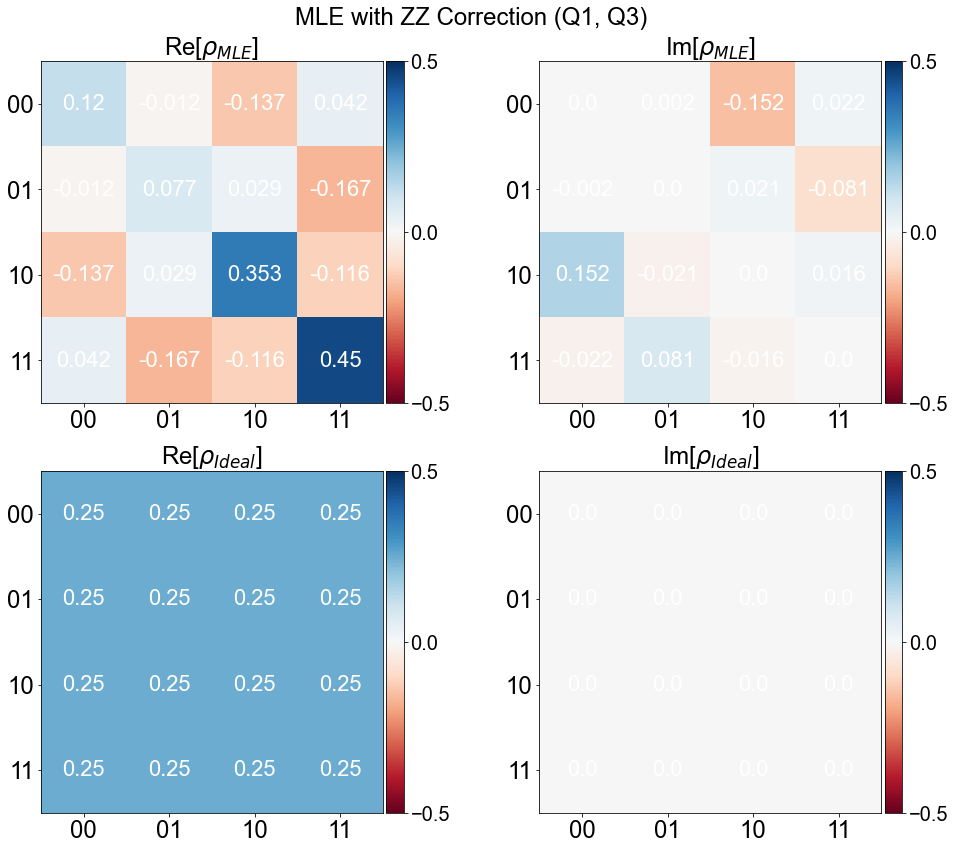

In [ ]:
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
# rho_MLE_ZZ = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
print(np.around(rho_MLE_ZZ, decimals=3))
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)

In [102]:
rho = qt.Qobj(inpt=rho_MLE_ZZ, dims=id2q.dims, shape=id2q.shape)
rho = rho.ptrace(1)
print(rho)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.50841296+0.j         0.37442144+0.10572826j]
 [0.37442144-0.10572826j 0.49158704+0.j        ]]


Optimize over virtual Z gate on rho_id

In [88]:
rho_MLE = rho_MLE_base

rho_id_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, nphi=30)

fid_rot = best_fid
purity_rot = np.real(np.trace(rho_MLE @ rho_MLE))
purity_id_rot = np.real(np.trace(rho_id_rot.full() @ rho_id_rot.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_rot}')
print(f'Target purity: {purity_id_rot}')
print(f'Best rotation: {best_phis}')

print(np.around(rho_MLE, decimals=3))
show_plot_rho_2d(rho_MLE, rho_id_rot, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=None, cmax=0.5)

100%|██████████| 30/30 [01:31<00:00,  3.05s/it]

Improved fidelity by (%) 1.1246767048635227


NameError: name 'fid_rot' is not defined

Fidelity (after rotation): 0.2240610989559508
Purity (after rotation): 0.34072049565324175
Target purity: 1.0
Best rotation: [161.37931034482762, 260.6896551724138, 161.37931034482762]
[[ 0.211+0.j    -0.027-0.j    -0.01 -0.019j -0.007+0.024j  0.081-0.057j
  -0.002+0.015j  0.009+0.024j -0.013+0.003j]
 [-0.027+0.j     0.029+0.j    -0.041-0.012j  0.003-0.001j -0.002+0.003j
  -0.016-0.025j  0.045-0.017j  0.003-0.011j]
 [-0.01 +0.019j -0.041+0.012j  0.247+0.j     0.011-0.017j  0.014+0.04j
   0.008-0.018j -0.179+0.126j  0.019+0.027j]
 [-0.007-0.024j  0.003+0.001j  0.011+0.017j  0.011+0.j    -0.013-0.017j
  -0.004-0.028j -0.01 -0.008j -0.005-0.j   ]
 [ 0.081+0.057j -0.002-0.003j  0.014-0.04j  -0.013+0.017j  0.117+0.j
   0.018+0.015j  0.007+0.036j  0.019-0.018j]
 [-0.002-0.015j -0.016+0.025j  0.008+0.018j -0.004+0.028j  0.018-0.015j
   0.162+0.j    -0.018+0.025j  0.014-0.015j]
 [ 0.009-0.024j  0.045+0.017j -0.179-0.126j -0.01 +0.008j  0.007-0.036j
  -0.018-0.025j  0.204+0.j     0.001-0.031j]


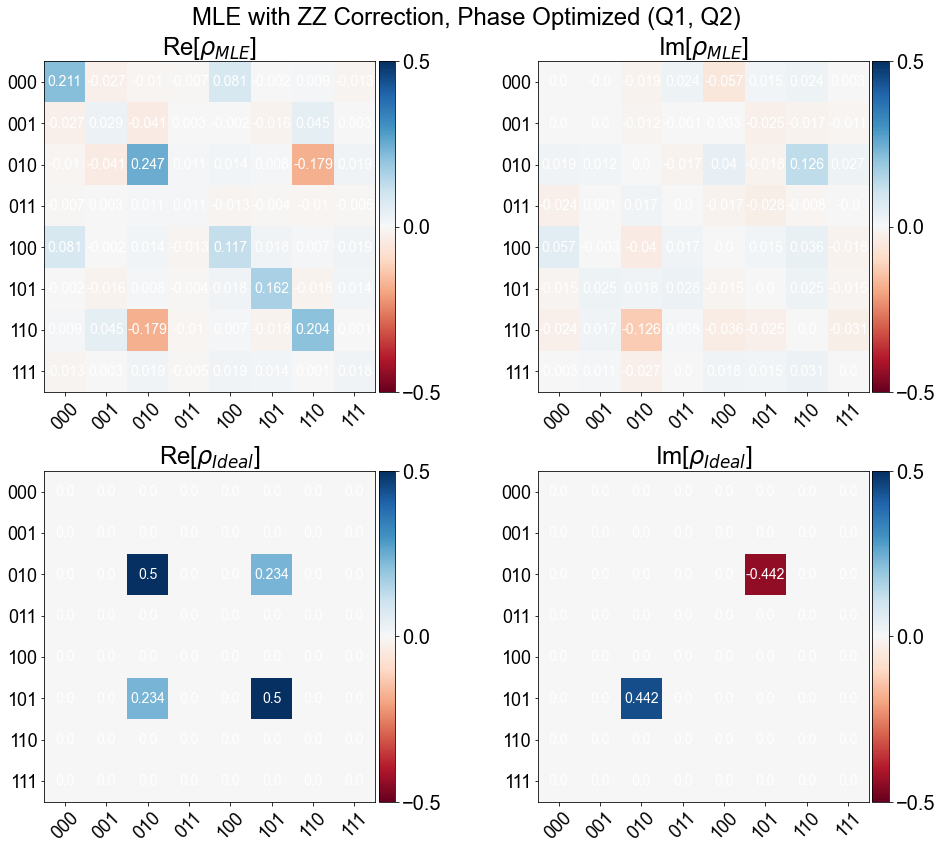

In [90]:
fid_rot = best_fid
purity_rot = np.real(np.trace(rho_MLE @ rho_MLE))
purity_id_rot = np.real(np.trace(rho_id_rot.full() @ rho_id_rot.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_rot}')
print(f'Target purity: {purity_id_rot}')
print(f'Best rotation: {best_phis}')

print(np.around(rho_MLE, decimals=3))
show_plot_rho_2d(rho_MLE, rho_id_rot, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=None, cmax=0.5)